In [11]:
import torch
import numpy as np
import pyrootutils
import sys
import os
import torch.nn.functional as F

# print(os.getcwd())
project_root = '../../'

src_path = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_path)

device = 'cpu'

# Load SAE weight & get dictionary vector
sae_checkpoint = torch.load('../../automated-concept-discovery-result/SAE-embeddings/autoencoder.pth', map_location=device)
dict_vec = sae_checkpoint['model_state_dict']['decoder._weight'].to(device).squeeze()
print(f"dict_vec: {dict_vec.shape}")

dict_vec: torch.Size([768, 6144])


In [12]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:redlessone/PanDerm2')
tokenizer = open_clip.get_tokenizer('hf-hub:redlessone/PanDerm2')

model = model.to(device)
print(f"Loading PanDermv2")

Loading PanDermv2


In [13]:
import torch.nn.functional as F

concept_list = ["asymmetry", "irregular", "erosion", "black", "blue", "white ", "brown" , "mutiple colors", "tiny", "regular"]

concept_embeddings = model.encode_text(tokenizer(concept_list).to(device))
concept_embeddings_norm = F.normalize(concept_embeddings, dim=-1)
concept_embeddings.shape

torch.Size([10, 768])

In [14]:
import torch
import numpy as np
device = 'cpu'

importances = np.load(f'../../automated-concept-discovery-result/dermoscopic-melanoma/mean_classifier_weights.npy')

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

import torch.nn.functional as F
def optimal_concept_matching(dict_vec, concept_embeddings_norm, 
                            importances, concept_list, device):
    """
    Use Hungarian algorithm to find globally optimal concept-to-neuron matching
    
    Args:
        dict_vec: Dictionary vectors (neurons) [feature_dim, num_neurons]
        concept_embeddings_norm: Normalized concept embeddings [num_concepts, feature_dim]
        importances: Importance scores for each neuron [num_neurons]
        concept_list: List of concept text descriptions
        device: Computing device
    
    Returns:
        matched_concepts: List of matching results sorted by concept order
        sorted_concepts: Matching results sorted by importance
    """
    # Calculate importance ranks (descending order: rank 0 = highest importance)
    importance_ranks = np.argsort(-np.abs(importances))  # Indices sorted by absolute importance
    rank_map = {neuron_idx: rank for rank, neuron_idx in enumerate(importance_ranks)}
    
    # Filter out neurons with zero importance
    non_zero_mask = importances != 0
    non_zero_indices = np.where(non_zero_mask)[0]
    
    print(f"Total neurons: {len(importances)}")
    print(f"Non-zero importance neurons: {len(non_zero_indices)}")
    
    # Extract only non-zero importance neurons
    dict_vec_filtered = dict_vec[:, non_zero_indices]
    importances_filtered = importances[non_zero_indices]
    
    # Compute similarity matrix
    similarity = concept_embeddings_norm @ dict_vec_filtered
    
    # Convert to numpy for Hungarian algorithm
    cost_matrix = -similarity.detach().cpu().numpy()
    
    # Use Hungarian algorithm to find optimal matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Build matching results
    matched_concepts = []
    for concept_idx, filtered_neuron_idx in zip(row_ind, col_ind):
        # Map back to original neuron index
        original_neuron_idx = non_zero_indices[filtered_neuron_idx]
        
        matched_concepts.append({
            'concept_idx': concept_idx,
            'concept': concept_list[concept_idx],
            'neuron_idx': original_neuron_idx,
            'similarity': similarity[concept_idx, filtered_neuron_idx].item(),
            'importance': importances[original_neuron_idx],
            'importance_rank': rank_map[original_neuron_idx]  # Add rank
        })
    
    # Sort by concept_idx
    matched_concepts.sort(key=lambda x: x['concept_idx'])
    
    # Sort by importance
    sorted_concepts = sorted(matched_concepts, key=lambda x: x['importance'], reverse=True)
    
    return matched_concepts, sorted_concepts

# Example usage:
matched, sorted_matched = optimal_concept_matching(
    dict_vec, concept_embeddings_norm, 
    importances, concept_list, device
)

# Print results with rank
print("\n=== Matched Concepts (by importance) ===")
for item in sorted_matched:
    print(f"Concept: {item['concept']:20s} -> Neuron {item['neuron_idx']:4d} | "
          f"Rank: {item['importance_rank']:4d}/{len(importances)} | "
          f"Importance: {item['importance']:+.6f} | Similarity: {item['similarity']:.4f}")

# Print summary statistics
print(f"\n=== Summary Statistics ===")
print(f"Average importance rank: {np.mean([item['importance_rank'] for item in matched]):.1f}")
print(f"Best rank: {min([item['importance_rank'] for item in matched])}")
print(f"Worst rank: {max([item['importance_rank'] for item in matched])}")

Total neurons: 6144
Non-zero importance neurons: 33

=== Matched Concepts (by importance) ===
Concept: white                -> Neuron  555 | Rank:    0/6144 | Importance: +18.926371 | Similarity: 0.2466
Concept: irregular            -> Neuron 1039 | Rank:    2/6144 | Importance: +6.964656 | Similarity: 0.2932
Concept: mutiple colors       -> Neuron 5738 | Rank:   11/6144 | Importance: +1.118896 | Similarity: 0.2950
Concept: erosion              -> Neuron 1656 | Rank:   16/6144 | Importance: +0.674169 | Similarity: 0.1572
Concept: brown                -> Neuron 1525 | Rank:   20/6144 | Importance: +0.256717 | Similarity: 0.2723
Concept: black                -> Neuron 2758 | Rank:   26/6144 | Importance: +0.046279 | Similarity: 0.3306
Concept: tiny                 -> Neuron 1969 | Rank:   30/6144 | Importance: -0.004037 | Similarity: 0.2972
Concept: blue                 -> Neuron 4507 | Rank:   25/6144 | Importance: -0.073208 | Similarity: 0.6156
Concept: regular              -> Neuron 2

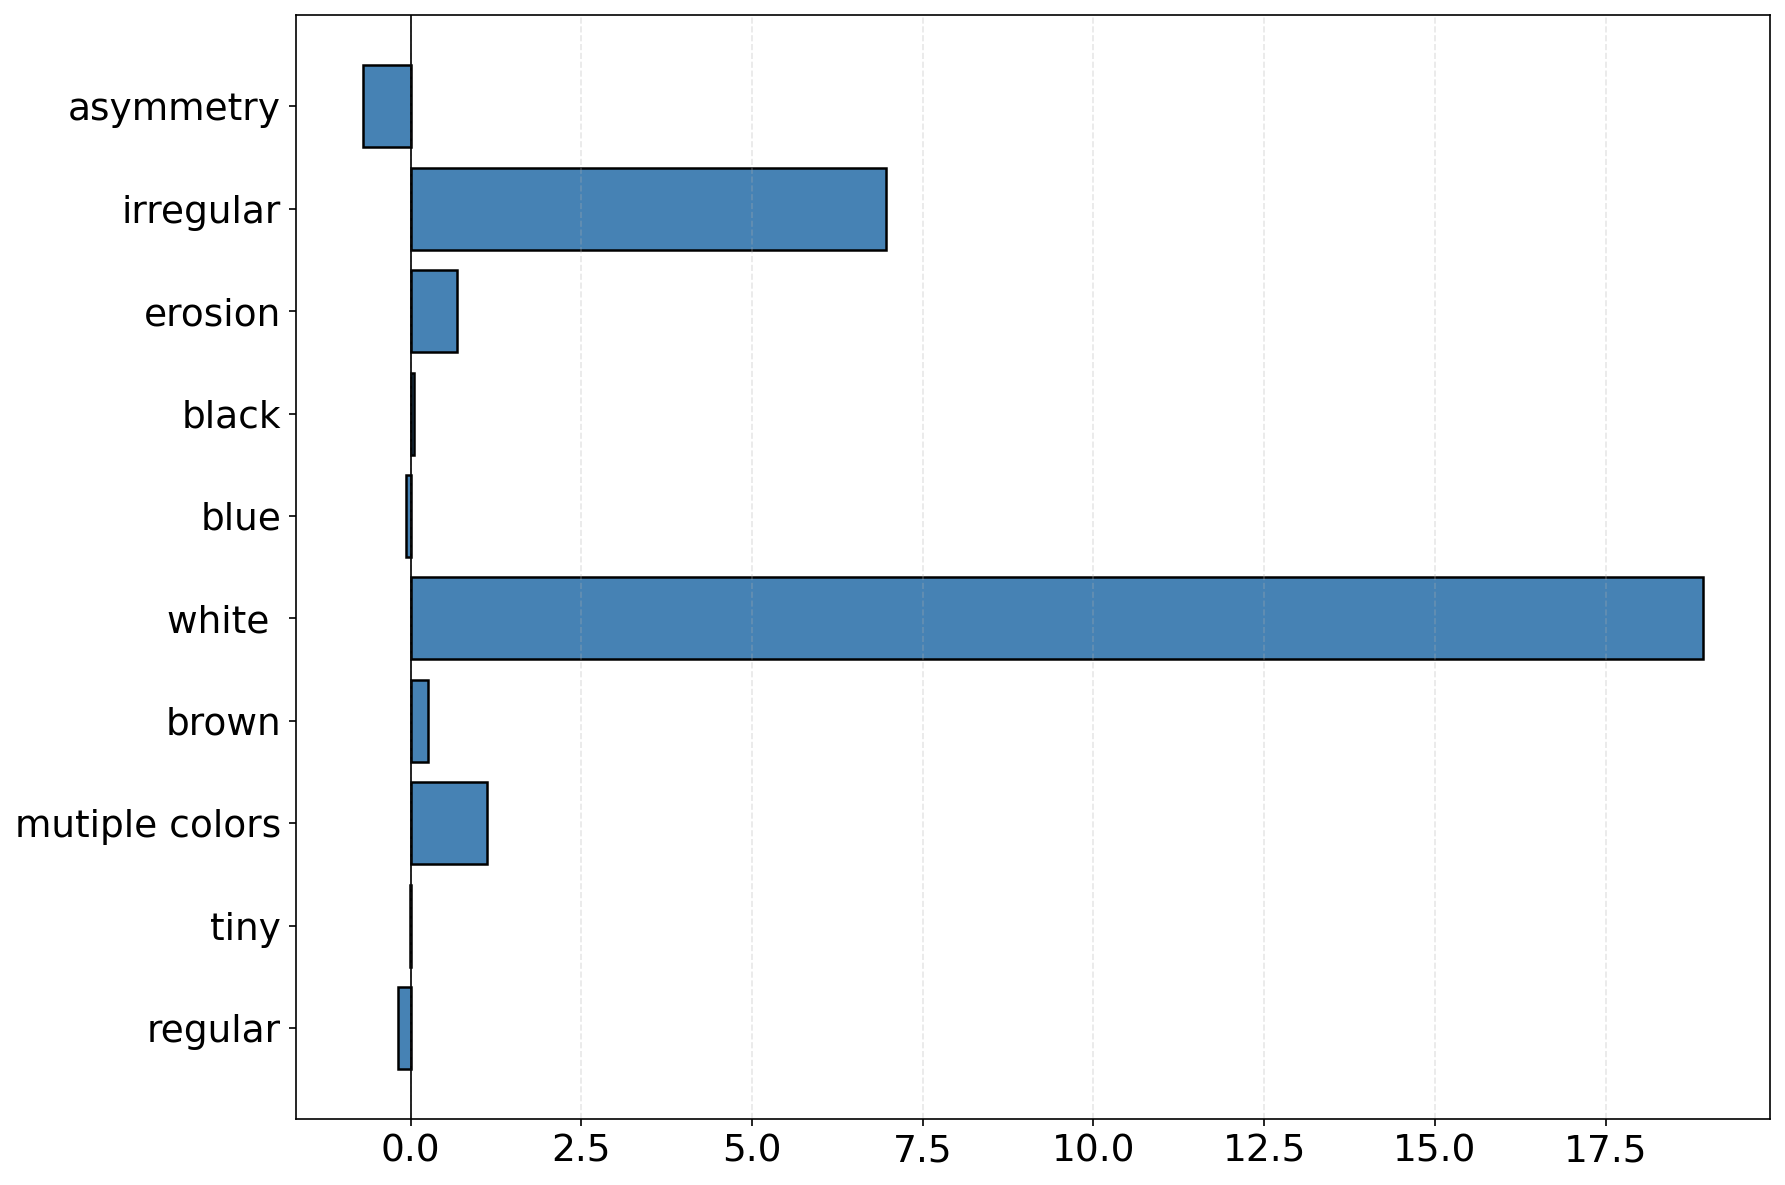


=== Matched Concepts ===
Concept: asymmetry            -> Neuron 2449 | Importance: -0.698898 | Similarity: 0.1265
Concept: irregular            -> Neuron 1039 | Importance: +6.964656 | Similarity: 0.2932
Concept: erosion              -> Neuron 1656 | Importance: +0.674169 | Similarity: 0.1572
Concept: black                -> Neuron 2758 | Importance: +0.046279 | Similarity: 0.3306
Concept: blue                 -> Neuron 4507 | Importance: -0.073208 | Similarity: 0.6156
Concept: white                -> Neuron  555 | Importance: +18.926371 | Similarity: 0.2466
Concept: brown                -> Neuron 1525 | Importance: +0.256717 | Similarity: 0.2723
Concept: mutiple colors       -> Neuron 5738 | Importance: +1.118896 | Similarity: 0.2950
Concept: tiny                 -> Neuron 1969 | Importance: -0.004037 | Similarity: 0.2972
Concept: regular              -> Neuron 2913 | Importance: -0.186406 | Similarity: 0.4070

Total similarity: 3.0412
Mean importance: 2.702454
Number of concepts ma

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get the matched concepts in the original concept_list order
concepts = [item['concept'] for item in matched][::-1]  # Reverse for bottom-to-top display
importances = [item['importance'] for item in matched][::-1]
similarities = [item['similarity'] for item in matched][::-1]
neuron_indices = [item['neuron_idx'] for item in matched][::-1]

# Create figure with single plot
plt.rcParams['figure.dpi'] = 150  # Increase DPI for sharper display
plt.rcParams['savefig.dpi'] = 300  # High quality when saving
fig, ax = plt.subplots(figsize=(12, 8))

# Plot: Importance
bars = ax.barh(concepts, importances, color='steelblue', edgecolor='black', linewidth=1.2)

# Increase font size for axis tick labels
ax.tick_params(axis='x', labelsize=18)  # X-axis coordinates (numbers)
ax.tick_params(axis='y', labelsize=18)  # Y-axis text (concepts)

ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

# Print detailed results in original order
print("\n=== Matched Concepts ===")
for item in matched:
    print(f"Concept: {item['concept']:20s} -> Neuron {item['neuron_idx']:4d} | "
          f"Importance: {item['importance']:+.6f} | Similarity: {item['similarity']:.4f}")

# Print summary statistics
total_similarity = sum(item['similarity'] for item in matched)
mean_importance = np.mean([item['importance'] for item in matched])
print(f"\nTotal similarity: {total_similarity:.4f}")
print(f"Mean importance: {mean_importance:.6f}")
print(f"Number of concepts matched: {len(matched)}")